In [1]:
%pip install --upgrade pip
%pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#@title Colab setup: GPU check + installs + imports
!nvidia-smi -L || echo "No GPU detected (CPU-only runtime)."

# OpenCV + tqdm (PyTorch is usually preinstalled in Colab)
# !pip install -q opencv-python tqdm

import os
import random
import hashlib
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


DATA_ZIP_URL = "https://datasets-cvlab.epfl.ch/2019-road-anomaly/RoadAnomaly_jpg.zip"
ZIP_NAME = "RoadAnomaly_jpg.zip"

if not os.path.exists(ZIP_NAME):
    !wget -q "{DATA_ZIP_URL}" -O "{ZIP_NAME}"
    print("Downloaded:", ZIP_NAME)
else:
    print("Zip file already exists, skipping download.")

!unzip -q -o "{ZIP_NAME}" -d .


# Dataset root (folder name after you upload/unzip RoadAnomaly_jpg)
DATASET_ROOT = "RoadAnomaly_jpg"

# If you upload a zip named RoadAnomaly_jpg.zip, auto-unzip it
zip_path = "RoadAnomaly_jpg.zip"
if (not os.path.isdir(DATASET_ROOT)) and os.path.isfile(zip_path):
    import zipfile
    print(f"Found {zip_path}, extracting to /content ...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall("/content")
    print("✅ Extraction done.")

@dataclass
class Config:
    dataset_root: str = DATASET_ROOT
    image_size: int = 512
    # Fractions for data split: must sum to 1.0
    train_fraction: float = 0.70
    val_fraction: float = 0.15
    test_fraction: float = 0.15
    batch_size: int = 4
    num_workers: int = 2
    num_epochs: int = 50          # bump this later if you want
    lr: float = 1e-4
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = Config()
print(cfg)

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.seed)
print(f"Using device: {cfg.device}")


GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-14d0ba8a-c20d-2b7a-0816-487286101197)
Zip file already exists, skipping download.
Zip file already exists, skipping download.
Config(dataset_root='RoadAnomaly_jpg', image_size=512, train_fraction=0.7, val_fraction=0.15, test_fraction=0.15, batch_size=4, num_workers=2, num_epochs=5, lr=0.0001, seed=42, device='cuda')
Using device: cuda
Config(dataset_root='RoadAnomaly_jpg', image_size=512, train_fraction=0.7, val_fraction=0.15, test_fraction=0.15, batch_size=4, num_workers=2, num_epochs=5, lr=0.0001, seed=42, device='cuda')
Using device: cuda


In [3]:
#@title Dataset helpers: scan images, create split, make dark images, build loaders

def get_frames_dir(cfg):
    frames_dir = os.path.join(cfg.dataset_root, "frames")
    if not os.path.isdir(frames_dir):
        print(f"❗ frames/ directory not found under {cfg.dataset_root}")
        print("   Make sure you uploaded/unzipped RoadAnomaly_jpg so that:")
        print("   /content/RoadAnomaly_jpg/frames/ contains the .jpg files.")
        return None
    return frames_dir

def list_bright_images(cfg):
    frames_dir = get_frames_dir(cfg)
    if frames_dir is None:
        return []
    bright_paths = sorted(str(p) for p in Path(frames_dir).glob("*.jpg"))
    if not bright_paths:
        print(f"❗ No .jpg images found in {frames_dir}")
    else:
        print(f"✅ Found {len(bright_paths)} bright images in {frames_dir}")
    return bright_paths

def create_or_load_split(cfg, bright_paths):
    n = len(bright_paths)
    if n == 0:
        return None, None, None

    # Basic sanity check on fractions
    total_frac = cfg.train_fraction + cfg.val_fraction + cfg.test_fraction
    if not np.isclose(total_frac, 1.0, atol=1e-6):
        raise ValueError(
            f"train/val/test fractions must sum to 1.0, got {total_frac} instead"
        )

    split_file = os.path.join(cfg.dataset_root, "split_indices.npz")
    if os.path.isfile(split_file):
        data = np.load(split_file, allow_pickle=True)
        train_idx = data["train_idx"]
        val_idx = data["val_idx"]
        # Backwards-compatible: if test_idx missing, create once and resave
        if "test_idx" in data.files:
            test_idx = data["test_idx"]
        else:
            print("ℹ️ Existing split found without test set; creating test indices with current config.")
            rng = np.random.RandomState(cfg.seed)
            indices = np.arange(n)
            rng.shuffle(indices)
            n_train = int(round(n * cfg.train_fraction))
            n_val = int(round(n * cfg.val_fraction))
            n_train = min(n_train, n)
            n_val = min(n_val, n - n_train)
            train_idx = indices[:n_train]
            val_idx = indices[n_train:n_train + n_val]
            test_idx = indices[n_train + n_val:]
            np.savez(split_file, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx)
        print(
            f"🔁 Loaded split from {split_file} "
            f"(train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)})"
        )
    else:
        rng = np.random.RandomState(cfg.seed)
        indices = np.arange(n)
        rng.shuffle(indices)

        n_train = int(round(n * cfg.train_fraction))
        n_val = int(round(n * cfg.val_fraction))
        # Ensure we don't exceed n and that all samples are used
        n_train = min(n_train, n)
        n_val = min(n_val, n - n_train)
        train_idx = indices[:n_train]
        val_idx = indices[n_train:n_train + n_val]
        test_idx = indices[n_train + n_val:]

        np.savez(split_file, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx)
        print(
            f"✂️ Created new split and saved to {split_file} "
            f"(train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)})"
        )

    return train_idx, val_idx, test_idx

def compute_image_seed(path: str, global_seed: int = 42) -> int:
    """Deterministic per-image seed from filename + global seed."""
    base = os.path.basename(path)
    h = hashlib.md5(base.encode("utf-8")).hexdigest()
    name_int = int(h[:8], 16) & 0xFFFFFFFF
    return (name_int ^ global_seed) & 0xFFFFFFFF

def darken_image_array(img_rgb: np.ndarray,
                       rng: np.random.RandomState,
                       gamma_range=(2.0, 4.0),
                       noise_std_range=(0.0, 0.05)) -> np.ndarray:
    """Apply gamma darkening + Gaussian noise in a reproducible way."""
    img = img_rgb.astype(np.float32) / 255.0
    gamma = rng.uniform(*gamma_range)
    noise_std = rng.uniform(*noise_std_range)
    dark = np.clip(img ** gamma, 0.0, 1.0)
    noise = rng.normal(0.0, noise_std, size=dark.shape).astype(np.float32)
    dark = np.clip(dark + noise, 0.0, 1.0)
    return (dark * 255.0).astype(np.uint8)

def ensure_dark_images(cfg, bright_paths):
    """
    For each bright frame, create a dark counterpart in frames_dark/
    using deterministic gamma & noise based on filename and cfg.seed.
    """
    dark_dir = os.path.join(cfg.dataset_root, "frames_dark")
    os.makedirs(dark_dir, exist_ok=True)
    created = 0
    for bright_path in bright_paths:
        name = os.path.basename(bright_path)
        dark_path = os.path.join(dark_dir, name)
        if os.path.isfile(dark_path):
            continue
        bgr = cv2.imread(bright_path, cv2.IMREAD_COLOR)
        if bgr is None:
            print(f"⚠️ Could not read {bright_path}, skipping.")
            continue
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        seed = compute_image_seed(bright_path, cfg.seed)
        rng = np.random.RandomState(seed)
        dark_rgb = darken_image_array(rgb, rng)
        dark_bgr = cv2.cvtColor(dark_rgb, cv2.COLOR_RGB2BGR)
        cv2.imwrite(dark_path, dark_bgr)
        created += 1
    print(f"✅ Dark images ready in {dark_dir}. Newly created: {created}")
    return dark_dir

def load_and_preprocess(path: str, image_size: int) -> np.ndarray:
    """
    Load path → RGB → resize so max(h,w)=image_size → pad to square → [0,1] float.
    """
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise RuntimeError(f"Could not read image: {path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    h, w = rgb.shape[:2]
    scale = image_size / max(h, w)
    new_w = int(round(w * scale))
    new_h = int(round(h * scale))
    rgb_resized = cv2.resize(rgb, (new_w, new_h), interpolation=cv2.INTER_AREA)
    top = (image_size - new_h) // 2
    bottom = image_size - new_h - top
    left = (image_size - new_w) // 2
    right = image_size - new_w - left
    rgb_padded = cv2.copyMakeBorder(
        rgb_resized, top, bottom, left, right, borderType=cv2.BORDER_REFLECT
    )
    img = rgb_padded.astype(np.float32) / 255.0  # H,W,3 in [0,1]
    return img

class RoadAnomalyPairs(Dataset):
    """
    Dataset of (dark, bright) image pairs using RoadAnomaly frames and
    precomputed frames_dark.
    """
    def __init__(self, cfg, bright_paths, indices):
        self.cfg = cfg
        self.bright_paths = bright_paths
        self.indices = [int(i) for i in indices]
        self.dark_dir = os.path.join(cfg.dataset_root, "frames_dark")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        bright_path = self.bright_paths[real_idx]
        name = os.path.basename(bright_path)
        dark_path = os.path.join(self.dark_dir, name)

        bright = load_and_preprocess(bright_path, self.cfg.image_size)
        dark   = load_and_preprocess(dark_path,   self.cfg.image_size)

        bright_t = torch.from_numpy(bright).permute(2, 0, 1)  # C,H,W
        dark_t   = torch.from_numpy(dark).permute(2, 0, 1)

        return {
            "dark": dark_t,
            "bright": bright_t,
            "path": bright_path,
        }

def create_dataloaders(cfg):
    bright_paths = list_bright_images(cfg)
    if not bright_paths:
        print("⛔ No bright images available. Upload/unzip RoadAnomaly_jpg and rerun this cell.")
        return None, None, bright_paths, (None, None, None)

    train_idx, val_idx, test_idx = create_or_load_split(cfg, bright_paths)
    if train_idx is None:
        return None, None, bright_paths, (None, None, None)

    ensure_dark_images(cfg, bright_paths)

    train_ds = RoadAnomalyPairs(cfg, bright_paths, train_idx)
    val_ds   = RoadAnomalyPairs(cfg, bright_paths, val_idx)

    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True,
    )
    print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
    # Return indices so we can later visualize strictly from test set
    return train_loader, val_loader, bright_paths, (train_idx, val_idx, test_idx)

print("✅ Dataset helpers ready.")


✅ Dataset helpers ready.


In [4]:
#@title UNet model definition (dark → bright)

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, base_ch=32):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, base_ch)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base_ch, base_ch * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(base_ch * 4, base_ch * 8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(base_ch * 8, base_ch * 16)

        self.up4 = nn.ConvTranspose2d(base_ch * 16, base_ch * 8, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(base_ch * 16, base_ch * 8)
        self.up3 = nn.ConvTranspose2d(base_ch * 8, base_ch * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base_ch * 8, base_ch * 4)
        self.up2 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_ch * 4, base_ch * 2)
        self.up1 = nn.ConvTranspose2d(base_ch * 2, base_ch, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_ch * 2, base_ch)

        self.out_conv = nn.Conv2d(base_ch, out_ch, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)
        e4 = self.enc4(p3); p4 = self.pool4(e4)

        b = self.bottleneck(p4)

        u4 = self.up4(b)
        d4 = self.dec4(torch.cat([u4, e4], dim=1))
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, e3], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))
        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))
        out = torch.sigmoid(self.out_conv(d1))
        return out

print("✅ UNet model defined.")


✅ UNet model defined.


In [5]:
#@title Train UNet and prediction helper (no visualization)

def train_unet(cfg):
    # Also get split indices to keep track of test set for visualization
    train_loader, val_loader, bright_paths, splits = create_dataloaders(cfg)
    train_idx, val_idx, test_idx = splits if splits is not None else (None, None, None)
    if train_loader is None:
        print("Training aborted: dataloaders not ready.")
        return None, {"bright_paths": bright_paths, "train_idx": train_idx, "val_idx": val_idx, "test_idx": test_idx}

    device = cfg.device
    model = UNet(in_ch=3, out_ch=3, base_ch=32).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)
    criterion = nn.L1Loss()

    best_val_loss = float("inf")
    best_state = None

    for epoch in range(cfg.num_epochs):
        model.train()
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.num_epochs} [train]"):
            dark = batch["dark"].to(device)
            bright = batch["bright"].to(device)

            optimizer.zero_grad()
            pred = model(dark)
            loss = criterion(pred, bright)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * dark.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}: train L1 = {train_loss:.4f}")

        model.eval()
        val_running = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{cfg.num_epochs} [val]"):
                dark = batch["dark"].to(device)
                bright = batch["bright"].to(device)
                pred = model(dark)
                loss = criterion(pred, bright)
                val_running += loss.item() * dark.size(0)
        val_loss = val_running / len(val_loader.dataset)
        print(f"Epoch {epoch+1}: val L1 = {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict().copy()
            print(f"🌟 New best model with val L1 = {best_val_loss:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    ckpt_dir = os.path.join(cfg.dataset_root, "checkpoints")
    os.makedirs(ckpt_dir, exist_ok=True)
    ckpt_path = os.path.join(ckpt_dir, "unet_dark_to_bright.pth")
    torch.save(model.state_dict(), ckpt_path)
    print(f"💾 Saved best model to {ckpt_path}")
    # Also return info needed for subset-only prediction
    meta = {"bright_paths": bright_paths, "train_idx": train_idx, "val_idx": val_idx, "test_idx": test_idx}
    return model, meta

def predict_on_subset(
    model,
    cfg,
    bright_paths=None,
    train_idx=None,
    val_idx=None,
    test_idx=None,
    subset: str = "test",
    choose_index: int = None,
):
    """
    Run model on one image from the chosen subset (train/val/test) and
    return a dict with: { 'bright_path', 'dark' (H,W,3 float [0,1]), 'pred' (H,W,3 float [0,1]), 'index' }.
    If choose_index is provided it must be an index into the global bright_paths array.
    """
    frames_dir = get_frames_dir(cfg)
    if frames_dir is None:
        raise RuntimeError("Dataset not ready")

    subset = subset.lower()
    if subset not in {"train", "val", "test"}:
        raise ValueError(f"subset must be one of 'train','val','test', got {subset}")

    # Reload split if needed
    if (bright_paths is None or train_idx is None or val_idx is None or test_idx is None):
        bright_paths_local = list_bright_images(cfg)
        if not bright_paths_local:
            raise RuntimeError("No bright images found")
        train_idx_local, val_idx_local, test_idx_local = create_or_load_split(cfg, bright_paths_local)
        bright_paths = bright_paths_local
        train_idx, val_idx, test_idx = train_idx_local, val_idx_local, test_idx_local

    if subset == "train":
        idx_array = train_idx
    elif subset == "val":
        idx_array = val_idx
    else:
        idx_array = test_idx

    if idx_array is None or len(idx_array) == 0:
        raise RuntimeError(f"No images available in subset '{subset}'")

    # choose a global index from the subset (or validate provided index)
    if choose_index is not None:
        if int(choose_index) not in list(idx_array):
            raise ValueError("choose_index must be one of the indices from the selected subset")
        global_idx = int(choose_index)
    else:
        import random as _random
        global_idx = int(_random.choice(idx_array))

    bright_path = bright_paths[global_idx]
    dark_dir = os.path.join(cfg.dataset_root, "frames_dark")
    dark_path = os.path.join(dark_dir, os.path.basename(bright_path))

    bright = load_and_preprocess(bright_path, cfg.image_size)  # H,W,3 float [0,1]
    dark = load_and_preprocess(dark_path, cfg.image_size)

    # Run model
    dark_t = torch.from_numpy(dark).permute(2, 0, 1).unsqueeze(0).to(cfg.device)
    model.eval()
    with torch.no_grad():
        pred_t = model(dark_t)
    pred = pred_t.squeeze(0).permute(1, 2, 0).cpu().numpy()
    pred = np.clip(pred, 0.0, 1.0)

    return {
        "bright_path": bright_path,
        "index": global_idx,
        "dark": dark,
        "pred": pred,
    }

# ---- Run training and keep model + meta ----
# cfg.num_epochs = 50
model, meta = train_unet(cfg)


✅ Found 60 bright images in RoadAnomaly_jpg/frames
🔁 Loaded split from RoadAnomaly_jpg/split_indices.npz (train=42, val=9, test=9)
✅ Dark images ready in RoadAnomaly_jpg/frames_dark. Newly created: 0
Train batches: 11, Val batches: 3


Epoch 1/5 [train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  9.37it/s]



Epoch 1: train L1 = 0.1726


Epoch 1/5 [val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.80it/s]


Epoch 1: val L1 = 0.2258
🌟 New best model with val L1 = 0.2258


Epoch 2/5 [train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.27it/s]


Epoch 2: train L1 = 0.1219


Epoch 2/5 [val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.17it/s]


Epoch 2: val L1 = 0.2130
🌟 New best model with val L1 = 0.2130


Epoch 3/5 [train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.26it/s]


Epoch 3: train L1 = 0.1011


Epoch 3/5 [val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 21.65it/s]


Epoch 3: val L1 = 0.1805
🌟 New best model with val L1 = 0.1805


Epoch 4/5 [train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.10it/s]


Epoch 4: train L1 = 0.0894


Epoch 4/5 [val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 21.36it/s]


Epoch 4: val L1 = 0.1426
🌟 New best model with val L1 = 0.1426


Epoch 5/5 [train]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.18it/s]


Epoch 5: train L1 = 0.0863


Epoch 5/5 [val]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 21.64it/s]

Epoch 5: val L1 = 0.1021
🌟 New best model with val L1 = 0.1021
💾 Saved best model to RoadAnomaly_jpg/checkpoints/unet_dark_to_bright.pth


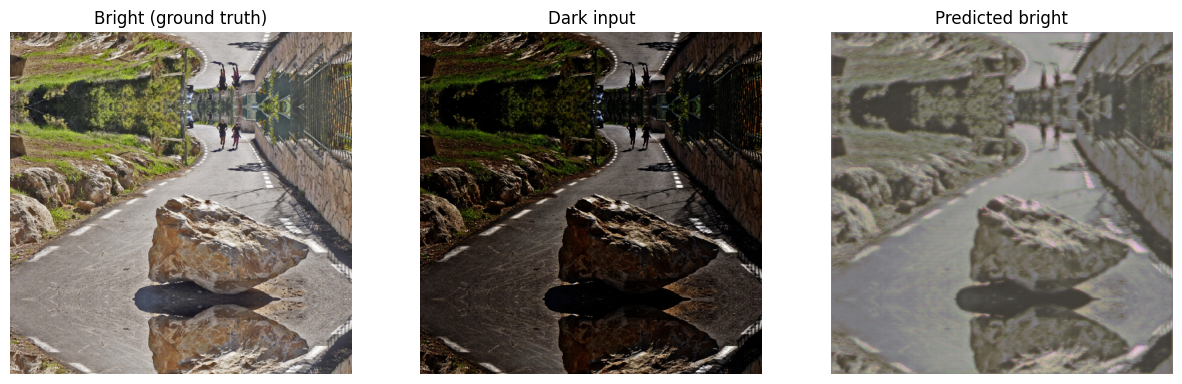

Plotted prediction_result for: RoadAnomaly_jpg/frames/obstacles01_boulder.jpg


In [13]:
# Use test set only and get predicted bright image (no visualization)
prediction_result = None
if model is not None and meta is not None:
    prediction_result = predict_on_subset(
        model,
        cfg,
        bright_paths=meta.get("bright_paths"),
        train_idx=meta.get("train_idx"),
        val_idx=meta.get("val_idx"),
        test_idx=meta.get("test_idx"),
        subset="test",
        choose_index=None,  # or set a global index if you want deterministic choice
    )
# Plot prediction_result (cell 7)
import matplotlib.pyplot as plt

if 'prediction_result' not in globals() or prediction_result is None:
    print('prediction_result not found. Run the prediction cell (cell 6) first to produce prediction_result.')
else:
    # bright_path -> load original bright (preprocessed to cfg.image_size)
    bright = load_and_preprocess(prediction_result['bright_path'], cfg.image_size)
    dark = prediction_result['dark']  # H,W,3 float in [0,1]
    pred = prediction_result['pred']  # H,W,3 float in [0,1]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(bright)
    axes[0].set_title('Bright (ground truth)')
    axes[0].axis('off')

    axes[1].imshow(dark)
    axes[1].set_title('Dark input')
    axes[1].axis('off')

    axes[2].imshow(pred)
    axes[2].set_title('Predicted bright')
    axes[2].axis('off')

    plt.show()
    print('Plotted prediction_result for:', prediction_result.get('bright_path'))

Using cache found in /home/syed/.cache/torch/hub/facebookresearch_dino_main


pred_features shape: (1, 768)


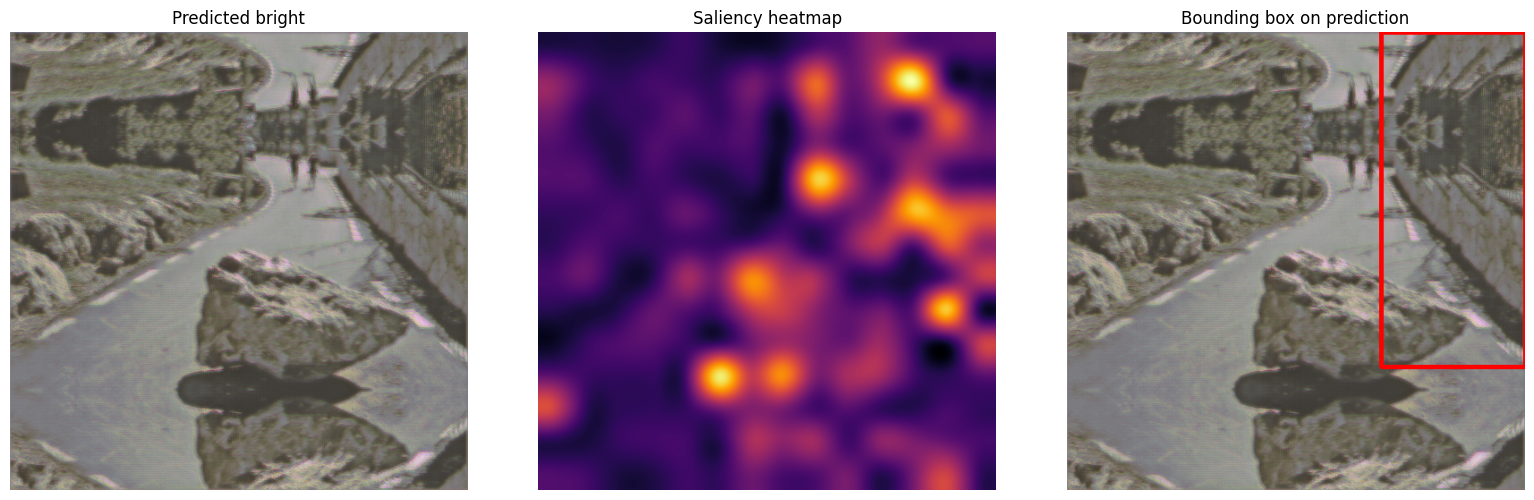

Bounding box: x=351, y=0, w=161, h=374


In [14]:
# Extract DINO / DINOv2 features from prediction_result['pred'] and store in `pred_features`
import sys, subprocess, importlib
import torch
from PIL import Image
import torchvision.transforms as T
import numpy as np

# Ensure prediction_result exists
if 'prediction_result' not in globals() or prediction_result is None:
    raise RuntimeError('prediction_result not found. Run the prediction cell first.')

# Try to load a DINO model via torch.hub (fallback to installing the repo if needed)
dino_model = None
try:
    dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16', pretrained=True)
except Exception as e:
    print('torch.hub load failed, attempting to install the repository and retry:', e)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'git+https://github.com/facebookresearch/dino.git'])
    importlib.invalidate_caches()
    try:
        dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16', pretrained=True)
    except Exception as e2:
        raise RuntimeError('Failed to load DINO model; adapt loader to your environment: ' + str(e2))

dino_model.eval()
dino_model.to(cfg.device)

# Convert prediction_result['pred'] (H,W,3 float in [0,1]) to PIL and preprocess
pred_img = (prediction_result['pred'] * 255).astype(np.uint8)
pil = Image.fromarray(pred_img)

# Standard ViT/DINO normalization and resize (adjust size if using a larger DINOv2 checkpoint)
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
inp = transform(pil).unsqueeze(0).to(cfg.device)

# Forward pass and robust extraction of features (try common API names)
with torch.no_grad():
    if hasattr(dino_model, 'forward_feature'):
        feats = dino_model.forward_feature(inp)
    elif hasattr(dino_model, 'extract_features'):
        feats = dino_model.extract_features(inp)
    else:
        out = dino_model(inp)
        if isinstance(out, dict):
            # pick first available tensor-like value
            feats = next((v for v in out.values() if torch.is_tensor(v)), None)
            if feats is None:
                raise RuntimeError('Model output dict did not contain tensor features.')
        else:
            feats = out

    # normalize shape: if list/tuple pick first element
    if isinstance(feats, (tuple, list)):
        feats = feats[0]

pred_features = feats.detach().cpu().numpy()
print('pred_features shape:', pred_features.shape)

# pred_features is now available for downstream models.
# Draw a bounding box on the predicted image using DINO attention (fallback to simple saliency)
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from PIL import Image
import torchvision.transforms as T

if 'prediction_result' not in globals() or prediction_result is None:
    raise RuntimeError('prediction_result not found. Run the prediction cell first.')

# Prepare predicted image
pred_img = (prediction_result['pred'] * 255).astype(np.uint8)  # H,W,3
H, W = pred_img.shape[:2]
pil = Image.fromarray(pred_img)

# Ensure dino_model is available without clobbering UNet `model`
if 'dino_model' not in globals() or dino_model is None:
    try:
        dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16', pretrained=True)
        dino_model.eval(); dino_model.to(cfg.device)
    except Exception as e:
        print('Failed to load dino_model in bbox cell:', e)
        dino_model = None

# Preprocess for ViT/DINO attention if available
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
inp_local = transform(pil).unsqueeze(0).to(cfg.device)

def norm01(x):
    x = x.astype(np.float32)
    x -= x.min()
    mx = x.max()
    if mx > 0:
        x /= mx
    return x

# Try to get attention-based heatmap from DINO
heatmap = None
try:
    if dino_model is not None and hasattr(dino_model, 'get_last_selfattention'):
        with torch.no_grad():
            attn = dino_model.get_last_selfattention(inp_local)  # [1, heads, tokens, tokens]
        attn = attn.squeeze(0).mean(0).cpu().numpy()  # [tokens, tokens] avg heads
        # CLS (0) attention to patch tokens (1:)
        if attn.shape[0] > 1 and int(np.sqrt(attn.shape[0]-1))**2 == (attn.shape[0]-1):
            cls_attn = attn[0, 1:]
            p = int(np.sqrt(cls_attn.shape[0]))
            att_map = cls_attn.reshape(p, p)
            heatmap = cv2.resize(norm01(att_map), (W, H), interpolation=cv2.INTER_CUBIC)
except Exception:
    heatmap = None

# Fallback: simple saliency from grayscale + threshold
if heatmap is None:
    gray = cv2.cvtColor(pred_img, cv2.COLOR_RGB2GRAY)
    # enhance contrast
    gray_eq = cv2.equalizeHist(gray)
    # threshold on upper intensity to get salient region
    _, mask = cv2.threshold(gray_eq, 200, 255, cv2.THRESH_BINARY)
    heatmap = norm01(mask.astype(np.float32))

# Derive bounding box from heatmap
hm = (heatmap * 255).astype(np.uint8)
hm_blur = cv2.GaussianBlur(hm, (7,7), 0)
_, hm_bin = cv2.threshold(hm_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

contours, _ = cv2.findContours(hm_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    print('No salient region found; drawing full image box.')
    x, y, w_box, h_box = 0, 0, W, H
else:
    c = max(contours, key=cv2.contourArea)
    x, y, w_box, h_box = cv2.boundingRect(c)

# Draw bounding box on a copy
boxed = pred_img.copy()
cv2.rectangle(boxed, (x, y), (x + w_box, y + h_box), (255, 0, 0), 3)  # red box

# Show predicted image and boxed result
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].imshow(pred_img)
axes[0].set_title('Predicted bright')
axes[0].axis('off')

axes[1].imshow(heatmap, cmap='inferno')
axes[1].set_title('Saliency heatmap')
axes[1].axis('off')

axes[2].imshow(boxed)
axes[2].set_title('Bounding box on prediction')
axes[2].axis('off')
plt.tight_layout()
plt.show()

print(f'Bounding box: x={x}, y={y}, w={w_box}, h={h_box}')